In [22]:
import pandas as pd 
import numpy as np
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout,Input,Conv1D,MaxPooling1D,Flatten,GRU,Embedding
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
import os

In [23]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [24]:
df=pd.read_json('./personality_captions/train.json')

In [25]:
df.head()

,comment,image_hash,personality
0,The snow will last as long as my sadness,1e22a9cf867d718551386b427c3b6d18,Intense
1,I love experiencing new cultures,96472caea58db27769f1c282e2ac0,Adventurous
2,Look at that smooth easy catch of the ball. li...,f09d8fb76822158de129acb0fef463,"Mellow (Soothing, Sweet)"
3,I wish I could just run down this shore!,6e4ccc739ff44ed11da20ad9892317,Zany
4,"Psh, I've seen way better floral arrangements....",e7e1844aa9e67cddc6ffe8804d76e45b,"Narcissistic (Self-centered, Egotistical)"


In [26]:
len(df['personality'].unique())

217

In [27]:
len(df)

186858

In [28]:
df['personality'] = df['personality'].astype('category').cat.codes

In [29]:
df.head()

,comment,image_hash,personality
0,The snow will last as long as my sadness,1e22a9cf867d718551386b427c3b6d18,120
1,I love experiencing new cultures,96472caea58db27769f1c282e2ac0,2
2,Look at that smooth easy catch of the ball. li...,f09d8fb76822158de129acb0fef463,130
3,I wish I could just run down this shore!,6e4ccc739ff44ed11da20ad9892317,216
4,"Psh, I've seen way better floral arrangements....",e7e1844aa9e67cddc6ffe8804d76e45b,138


In [30]:
y_train=df.personality

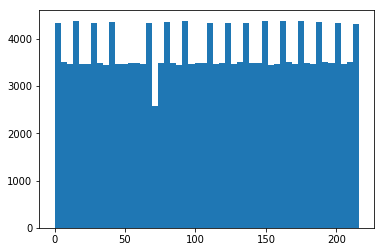

In [31]:
plt.hist(y_train, bins = 50)
plt.show()

In [32]:
tokenizer_obj=Tokenizer()

In [33]:
tokenizer_obj.fit_on_texts(df.comment)

In [34]:
max_length=max([len(s.split())for s in df.comment])

In [35]:
max_length

114

In [36]:
vocab_size=len(tokenizer_obj.word_index)+1

In [37]:
x_train_tokens=tokenizer_obj.texts_to_sequences(df.comment)

In [38]:
x_train_pad=pad_sequences(x_train_tokens, maxlen=max_length, padding='post')

In [39]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Model

In [40]:
EMBEDDING_DIM=150

In [41]:
print ("Create model ... ")
def build_model():
    model = Sequential()
    model.add(Embedding(vocab_size,EMBEDDING_DIM, input_length=max_length))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.3))
#     model.add(Dense(350, activation='relu'))
#     model.add(Dropout(0.3))    
    model.add(Dense(217, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m])
    model.summary()
    return model

Create model ... 


In [42]:
print("Compile model ...")
estimator = KerasClassifier(build_fn=build_model, epochs=400, batch_size=256)
with tf.device('/gpu:0'):
    estimator.fit(x_train_pad, y_train)

Compile model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 114, 150)          5092650   
_________________________________________________________________
flatten_2 (Flatten)          (None, 17100)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               8550500   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 217)               108

186858/186858 [==============================] - 12s 65us/step - loss: 0.7749 - acc: 0.7921 - f1_m: 0.8105
Epoch 58/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.7660 - acc: 0.7936 - f1_m: 0.8119
Epoch 59/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.7591 - acc: 0.7954 - f1_m: 0.8136
Epoch 60/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.7585 - acc: 0.7948 - f1_m: 0.8128
Epoch 61/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.7487 - acc: 0.7994 - f1_m: 0.8169
Epoch 62/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.7481 - acc: 0.7986 - f1_m: 0.8163
Epoch 63/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.7397 - acc: 0.8015 - f1_m: 0.8185
Epoch 64/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.7439 - acc: 0.8003 - f1_m: 0.8180
Epoch 65/1000
186858/186858 [=================

186858/186858 [==============================] - 12s 65us/step - loss: 0.5915 - acc: 0.8420 - f1_m: 0.8561
Epoch 125/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.5979 - acc: 0.8419 - f1_m: 0.8558
Epoch 126/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.5930 - acc: 0.8422 - f1_m: 0.8563
Epoch 127/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.5897 - acc: 0.8429 - f1_m: 0.8562
Epoch 128/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.5905 - acc: 0.8429 - f1_m: 0.8571
Epoch 129/1000
186858/186858 [==============================] - 12s 64us/step - loss: 0.5854 - acc: 0.8443 - f1_m: 0.8579
Epoch 130/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.5821 - acc: 0.8447 - f1_m: 0.8579
Epoch 131/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.5839 - acc: 0.8444 - f1_m: 0.8582
Epoch 132/1000
186858/186858 [=========

186858/186858 [==============================] - 12s 64us/step - loss: 0.5301 - acc: 0.8607 - f1_m: 0.8733
Epoch 192/1000
186858/186858 [==============================] - 12s 64us/step - loss: 0.5245 - acc: 0.8622 - f1_m: 0.8741
Epoch 193/1000
186858/186858 [==============================] - 12s 64us/step - loss: 0.5270 - acc: 0.8613 - f1_m: 0.8735
Epoch 194/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.5206 - acc: 0.8633 - f1_m: 0.8755
Epoch 195/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.5226 - acc: 0.8630 - f1_m: 0.8754
Epoch 196/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.5186 - acc: 0.8637 - f1_m: 0.8756
Epoch 197/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.5268 - acc: 0.8624 - f1_m: 0.8743
Epoch 198/1000
186858/186858 [==============================] - 12s 64us/step - loss: 0.5280 - acc: 0.8625 - f1_m: 0.8747
Epoch 199/1000
186858/186858 [=========

Epoch 258/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.4913 - acc: 0.8735 - f1_m: 0.8843
Epoch 259/1000
186858/186858 [==============================] - 12s 64us/step - loss: 0.4923 - acc: 0.8729 - f1_m: 0.8841
Epoch 260/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.4853 - acc: 0.8740 - f1_m: 0.8854
Epoch 261/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.4923 - acc: 0.8720 - f1_m: 0.8837
Epoch 262/1000
186858/186858 [==============================] - 12s 64us/step - loss: 0.4917 - acc: 0.8731 - f1_m: 0.8843
Epoch 263/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.4883 - acc: 0.8735 - f1_m: 0.8848
Epoch 264/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.4947 - acc: 0.8723 - f1_m: 0.8835
Epoch 265/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.4869 - acc: 0.8743 - f1_m: 0.8856
Epoch 266/1000
186858/18

186858/186858 [==============================] - 12s 65us/step - loss: 0.4707 - acc: 0.8816 - f1_m: 0.8923
Epoch 326/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.4682 - acc: 0.8806 - f1_m: 0.8912
Epoch 327/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.4692 - acc: 0.8808 - f1_m: 0.8916
Epoch 328/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.4671 - acc: 0.8805 - f1_m: 0.8912
Epoch 329/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.4700 - acc: 0.8812 - f1_m: 0.8916
Epoch 330/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.4676 - acc: 0.8815 - f1_m: 0.8918
Epoch 331/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.4682 - acc: 0.8812 - f1_m: 0.8920
Epoch 332/1000
186858/186858 [==============================] - 12s 65us/step - loss: 0.4664 - acc: 0.8816 - f1_m: 0.8927
Epoch 333/1000
186858/186858 [=========

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
# cv
# kfold = KFold(n_splits=10, shuffle=True)
# with tf.device('/gpu:0'):
#     results = cross_val_score(estimator, train_x, train_y, cv=kfold)

In [ ]:
# print(results.mean())

## Saving model

In [43]:
model_json = estimator.model.to_json()

In [44]:
with open("./keras_model/per_model.json", "w") as json_file:
    json_file.write(model_json)

In [45]:
estimator.model.save_weights("./keras_model/per_model.h5")

## Restoring model

In [46]:
from keras.models import model_from_json

In [47]:
# load json and create model
json_file = open('./keras_model/per_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./keras_model/per_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [48]:
persona_dic = {0: 'Abrasive (Annoying, Irritating)',
 1: 'Absentminded',
 2: 'Adventurous',
 3: 'Aggressive',
 4: 'Airy (Casual, Not Serious)',
 5: 'Aloof (Detached, Distant)',
 6: 'Amusing',
 7: 'Angry',
 8: 'Anxious',
 9: 'Apathetic (Uncaring, Disinterested)',
 10: 'Appreciative (Grateful)',
 11: 'Argumentative',
 12: 'Arrogant',
 13: 'Artful',
 14: 'Articulate (Well-spoken, Expressive)',
 15: 'Artificial',
 16: 'Assertive',
 17: 'Attractive',
 18: 'Barbaric',
 19: 'Bewildered (Astonished, Confused)',
 20: 'Bizarre',
 21: 'Bland',
 22: 'Blunt',
 23: 'Boisterous (Rowdy, Loud)',
 24: 'Boyish',
 25: 'Breezy (Relaxed, Informal)',
 26: 'Brilliant',
 27: 'Businesslike',
 28: 'Calm',
 29: 'Captivating',
 30: 'Caring',
 31: 'Casual',
 32: 'Cerebral (Intellectual, Logical)',
 33: 'Charming',
 34: 'Cheerful',
 35: 'Childish',
 36: 'Clever',
 37: 'Coarse (Not Fine, Crass)',
 38: 'Cold',
 39: 'Colorful (Full of Life, Interesting)',
 40: 'Compassionate (Sympathetic, Warm)',
 41: 'Complex',
 42: 'Conceited (Arrogant, Egotistical)',
 43: 'Confident',
 44: 'Confused',
 45: 'Conservative (Traditional, Conventional)',
 46: 'Considerate',
 47: 'Contemplative (Reflective, Thoughtful)',
 48: 'Contemptible (Despicable, Vile)',
 49: 'Contradictory',
 50: 'Courageous',
 51: 'Cowardly',
 52: 'Crazy',
 53: 'Creative',
 54: 'Critical',
 55: 'Crude',
 56: 'Cruel',
 57: 'Cultured (Refined, Educated)',
 58: 'Curious',
 59: 'Cute',
 60: 'Cynical (Doubtful, Skeptical)',
 61: 'Daring',
 62: 'Deep',
 63: 'Destructive',
 64: 'Devious',
 65: 'Discouraging',
 66: 'Disturbing',
 67: 'Dramatic',
 68: 'Dreamy',
 69: 'Dry',
 70: 'Dull',
 71: 'Earnest',
 72: 'Earnest (Enthusiastic)',
 73: 'Egocentric (Self-centered)',
 74: 'Elegant',
 75: 'Eloquent (Well-spoken, Expressive)',
 76: 'Emotional',
 77: 'Empathetic',
 78: 'Energetic',
 79: 'Enigmatic (Cryptic, Obscure)',
 80: 'Enthusiastic',
 81: 'Envious',
 82: 'Erratic',
 83: 'Escapist (Dreamer, Seeks Distraction)',
 84: 'Excitable',
 85: 'Exciting',
 86: 'Extraordinary',
 87: 'Extravagant',
 88: 'Extreme',
 89: 'Fanatical',
 90: 'Fanciful',
 91: 'Fatalistic (Bleak, Gloomy)',
 92: 'Fawning (Flattering, Deferential)',
 93: 'Fearful',
 94: 'Fickle (Changeable, Temperamental)',
 95: 'Fiery',
 96: 'Foolish',
 97: 'Formal',
 98: 'Freethinking',
 99: 'Frightening',
 100: 'Frivolous (Trivial, Silly)',
 101: 'Fun-loving',
 102: 'Gentle',
 103: 'Glamorous',
 104: 'Gloomy',
 105: 'Grand',
 106: 'Grim',
 107: 'Happy',
 108: 'Hateful',
 109: 'Haughty (Arrogant, Snobbish)',
 110: 'High-spirited',
 111: 'Honest',
 112: 'Hostile',
 113: 'Humble',
 114: 'Humorous',
 115: 'Idealistic',
 116: 'Imaginative',
 117: 'Impersonal',
 118: 'Insightful',
 119: 'Intelligent',
 120: 'Intense',
 121: 'Irrational',
 122: 'Irritable',
 123: 'Kind',
 124: 'Knowledgeable',
 125: 'Lazy',
 126: 'Logical',
 127: 'Malicious',
 128: 'Maternal (Mother-like)',
 129: 'Melancholic',
 130: 'Mellow (Soothing, Sweet)',
 131: 'Meticulous (Precise, Thorough)',
 132: 'Miserable',
 133: 'Money-minded',
 134: 'Monstrous',
 135: 'Moody',
 136: 'Morbid',
 137: 'Mystical',
 138: 'Narcissistic (Self-centered, Egotistical)',
 139: 'Neurotic (Manic, Obsessive)',
 140: 'Neutral',
 141: 'Nihilistic',
 142: 'Objective (Detached, Impartial)',
 143: 'Obnoxious',
 144: 'Observant',
 145: 'Obsessive',
 146: 'Odd',
 147: 'Offhand',
 148: 'Old-fashioned',
 149: 'Open',
 150: 'Opinionated',
 151: 'Optimistic',
 152: 'Ordinary',
 153: 'Outrageous',
 154: 'Overimaginative',
 155: 'Paranoid',
 156: 'Passionate',
 157: 'Passive',
 158: 'Patriotic',
 159: 'Peaceful',
 160: 'Perceptive',
 161: 'Playful',
 162: 'Pompous (Self-important, Arrogant)',
 163: 'Practical',
 164: 'Pretentious (Snobbish, Showy)',
 165: 'Profound',
 166: 'Provocative',
 167: 'Questioning',
 168: 'Quirky',
 169: 'Rational',
 170: 'Realistic',
 171: 'Reflective',
 172: 'Relaxed',
 173: 'Resentful',
 174: 'Respectful',
 175: 'Ridiculous',
 176: 'Rigid',
 177: 'Romantic',
 178: 'Rowdy',
 179: 'Rustic (Rural)',
 180: 'Sarcastic',
 181: 'Scholarly',
 182: 'Scornful',
 183: 'Sensitive',
 184: 'Sensual',
 185: 'Sentimental',
 186: 'Serious',
 187: 'Shy',
 188: 'Silly',
 189: 'Simple',
 190: 'Skeptical',
 191: 'Solemn',
 192: 'Sophisticated',
 193: 'Spirited',
 194: 'Spontaneous',
 195: 'Stiff',
 196: 'Stoic (Unemotional, Matter-of-fact)',
 197: 'Stupid',
 198: 'Stylish',
 199: 'Suave (Charming, Smooth)',
 200: 'Sweet',
 201: 'Sympathetic',
 202: 'Tense',
 203: 'Tough',
 204: 'Uncreative',
 205: 'Unimaginative',
 206: 'Unrealistic',
 207: 'Vacuous (Empty, Unintelligent)',
 208: 'Vague',
 209: 'Vivacious (Lively, Animated)',
 210: 'Warm',
 211: 'Whimsical (Playful, Fanciful)',
 212: 'Wise',
 213: 'Wishful',
 214: 'Witty',
 215: 'Youthful',
 216: 'Zany'}

In [49]:
def classify(test_sentence, persona_dic, loaded_model, tokenizer_obj):
    sent=[test_sentence]
    x_train_tokens=tokenizer_obj.texts_to_sequences(sent)
    x_train_pad=pad_sequences(x_train_tokens, maxlen=114, padding='post')
    result=loaded_model.predict(x=x_train_pad)
    return persona_dic[np.argmax(result)]

In [50]:
test_sentence='Nice beard my friend! want to compete with my'

In [51]:
classify(test_sentence, persona_dic, loaded_model, tokenizer_obj)

'Playful'

In [65]:
# check

In [66]:
df[df['comment'].str.contains("Nice beard my friend! want to compete with my")]

,comment,image_hash,personality
168488,Nice beard my friend! want to compete with my!?,c9caf6c098068c13eeb10e6266046d3,161
